## 掛載雲端硬碟


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## 更改檔案所在路徑

In [2]:
# Change to your own folder !!!
# %cd /content/drive/MyDrive/your own folder/

## Import library

In [3]:
!pip install thop
!pip install torchsummary
!pip install matplotlib


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [4]:
import os
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from models.resnet import ResNet50

## FLOPs & Parameters & Architecture
若`resnet.py`有寫對，這部分會能夠正常跑，且 parameters 應為 23513162。

你也可以寫一個剪枝後可能的 cfg 作為模型的輸入參數，看這部分印出來的架構是否正確。

In [5]:
from thop import profile
from torchsummary import summary

model = ResNet50(num_classes=10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
model = model.to(device)

dummy_input = torch.randn(1, 3, 32, 32).to(device)
flops, params = profile(model, inputs=(dummy_input, ))

print(f"FLOPs: {flops}")
print(f"Params: {params}")
summary(model, input_size=(3, 32, 32))

Device: cuda
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 329439232.0
Params: 23520842.0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]          

## 設定超參數(請填空 λ)

In [6]:
SPARSITY_REGULARIZATION = True
#### 設定λ(balance factor) ####
################################################
#          請填空          #
################################################
LAMBDA = 1e-4  # 0 or 1e-5 or 1e-4

SEED = 1
TRAIN_BATCH_SIZE = 100
TEST_BATCH_SIZE = 1000

EPOCHS = 40
LEARNING_RATE = 1e-3

LOG_INTERVAL = 100
CUDA = True

RESUME = False
START_EPOCH = 0

WEIGHT_PATH = 'model_best.pth' # Change to your own folder !!!

In [7]:
if(torch.cuda.is_available()):
    CUDA = True
    kwargs = {'num_workers': 1, 'pin_memory': True}
    torch.cuda.manual_seed(SEED)
else:
    CUDA = False
    kwargs = {}


## 下載資料集


這裡將訓練集做Augmentation(Pad, RandCrop, Random)，測試集不用做Augmentation

In [8]:
#### 資料集 ####
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Pad(4),
                       transforms.RandomCrop(32),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                   ])),
    batch_size=TRAIN_BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, **kwargs)

## 定義模型與設定Optimizer & CrossEntropy Loss


In [9]:
# cfg = [64, 64, 64, 256, 64, 64, 256, 64, 64, 256, 128, 128, 512, 128, 128, 512, 128, 128, 512, 128, 128, 512, 256, 256, 1024, 256, 256, 1024, 256, 256, 1024, 256, 256, 1024, 256, 256, 1024, 256, 256, 1024, 512, 512, 2048, 512, 512, 2048, 512, 512, 2048]

model = ResNet50(num_classes=10)
if CUDA:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

## 使用論文中稀疏化的方式更新參數(請填空)

In [10]:
def updateBN():
  for m in model.modules():
      if isinstance(m, nn.BatchNorm2d):
          #### 完成Sparsity Regularization ####
          ################################################
          #          請填空          #
          ################################################
          
          # 在稀疏化訓練中，對 BN 的 weight 加上梯度 = λ * sign(weight)
          m.weight.grad.data.add_(LAMBDA * torch.sign(m.weight.data))


## 定義訓練跟測試函數
需自行撰寫儲存每個epoch之train acc與test acc的code，以便後續繪製train acc與test acc結果圖!

In [11]:
#### 訓練函數 #####

# 注意: 需自行撰寫儲存每個epoch之train acc與test acc的code，以便後續繪製train acc與test acc結果圖!

train_acc_list = []
test_acc_list = []

def train(epoch):
    model.train()
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        if CUDA:
            data, target = data.cuda(), target.cuda()

        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, target)
        loss.backward()

        # ----------- Sparsity Regularization -----------
        if SPARSITY_REGULARIZATION:
            updateBN()
        optimizer.step()
        # ------------------------------------------------

        # === 計算本 batch 正確數 ===
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum().item()
        total += target.size(0)

        # === 每 LOG_INTERVAL 顯示一次訓練狀態 ===
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

    # === 計算整個 epoch 的訓練集準確率 ===
    acc = correct / total
    train_acc_list.append(acc)
    print(f'Epoch {epoch}: Train Accuracy = {acc:.4f}')


#### 測試函數 ####
def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            if CUDA:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)

            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)

            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    acc = correct / float(len(test_loader.dataset))
    test_acc_list.append(acc)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return acc


##########################################################################################

best_prec1 = 0.
for epoch in range(START_EPOCH, EPOCHS):
    # Learning Rate 在 0.5EPOCHS 與 0.75EPOCHS 調整為原本 1/10
    if epoch in [EPOCHS*0.5, EPOCHS*0.75]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1

    train(epoch)
    prec1 = test()

    # 儲存模型權重，方便後續剪枝與微調
    if prec1 > best_prec1:
        best_prec1 = prec1
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer': optimizer.state_dict(),
        }, WEIGHT_PATH)

    best_prec1 = max(prec1, best_prec1)

Train Epoch: 0 [0/50000 (0.0%)]	Loss: 2.618000
Train Epoch: 0 [10000/50000 (20.0%)]	Loss: 1.814992
Train Epoch: 0 [20000/50000 (40.0%)]	Loss: 1.711462
Train Epoch: 0 [30000/50000 (60.0%)]	Loss: 1.895940
Train Epoch: 0 [40000/50000 (80.0%)]	Loss: 1.455839
Epoch 0: Train Accuracy = 0.3569

Test set: Average loss: 1.3895, Accuracy: 4894/10000 (48.9%)

Train Epoch: 1 [0/50000 (0.0%)]	Loss: 1.450131
Train Epoch: 1 [10000/50000 (20.0%)]	Loss: 1.484389
Train Epoch: 1 [20000/50000 (40.0%)]	Loss: 1.439680
Train Epoch: 1 [30000/50000 (60.0%)]	Loss: 1.446298
Train Epoch: 1 [40000/50000 (80.0%)]	Loss: 1.162574
Epoch 1: Train Accuracy = 0.5206

Test set: Average loss: 1.5470, Accuracy: 5693/10000 (56.9%)

Train Epoch: 2 [0/50000 (0.0%)]	Loss: 1.177970
Train Epoch: 2 [10000/50000 (20.0%)]	Loss: 1.138844
Train Epoch: 2 [20000/50000 (40.0%)]	Loss: 1.096656
Train Epoch: 2 [30000/50000 (60.0%)]	Loss: 1.193257
Train Epoch: 2 [40000/50000 (80.0%)]	Loss: 0.988427
Epoch 2: Train Accuracy = 0.6129

Test set:

## 繪製Sparsity-Training結果圖

In [12]:


save_dir = "./results"
os.makedirs(save_dir, exist_ok=True)

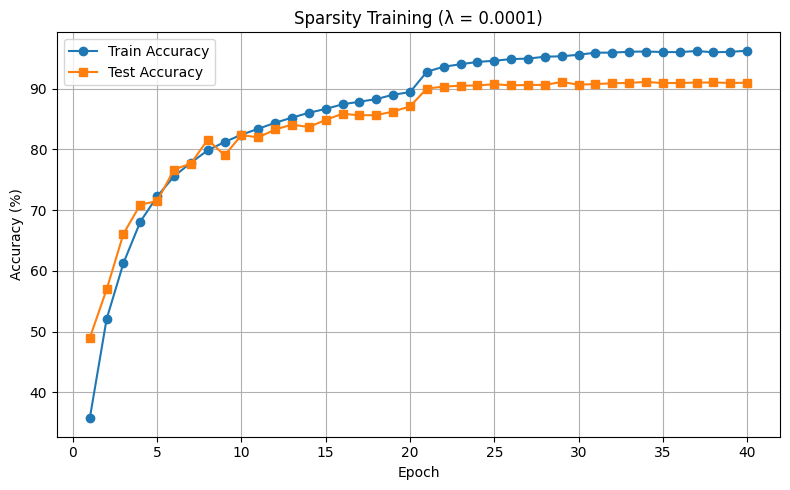

In [15]:
#繪製 Sparsity-Training 結果圖


train_acc_percent = [acc * 100 for acc in train_acc_list]
test_acc_percent = [acc * 100 for acc in test_acc_list]

epochs = range(1, EPOCHS + 1)
plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc_percent, label='Train Accuracy', marker='o')
plt.plot(epochs, test_acc_percent, label='Test Accuracy', marker='s')
plt.title(f"Sparsity Training (λ = {LAMBDA})")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
# plt.grid(True, linestyle="--", alpha=0.6)
plt.grid(True)

plt.tight_layout()

save_path = os.path.join(save_dir, f"sparsity_training_acc_lambda_{LAMBDA}.png")
plt.savefig(save_path, dpi=300)
plt.show()


## 繪製scaling factor 分布圖

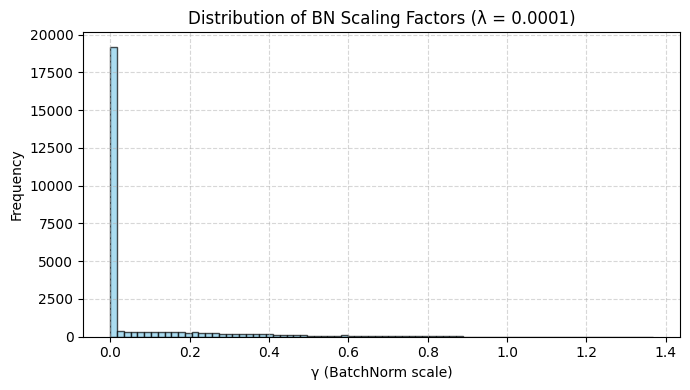

In [14]:
#繪製 scaling factor 分布圖


all_gamma = []
for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
        all_gamma.append(m.weight.data.abs().cpu().numpy())

# 合併所有 γ 值
all_gamma = np.concatenate(all_gamma)

plt.figure(figsize=(7,4))
plt.hist(all_gamma, bins=80, color='skyblue', edgecolor='k', alpha=0.7)
plt.title(f"Distribution of BN Scaling Factors (λ = {LAMBDA})")
plt.xlabel("γ (BatchNorm scale)")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()



save_path = os.path.join(save_dir, f"bn_distribution_lambda_{LAMBDA}.png")
plt.savefig(save_path, dpi=300)
plt.show()